# DBScan

In [2]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [3]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Create data

In [4]:
n_clusters = 6
n_samples = 250

To generate our data, we're going to pick 6 random points, which we'll call centroids, and for each point we're going to generate 250 random points about it.

In [5]:
centroids = torch.rand(n_clusters, 2)*70-35

In [6]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [7]:
torch.diag(tensor([5.,5.]))

tensor([[5., 0.],
        [0., 5.]])

In [8]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [9]:
slices = [sample(c) for c in centroids]

In [10]:
def plot_data(data, ax=None):
    if ax is None: _,ax = plt.subplots()
    for group in data:
        ax.scatter(group[:,0], group[:,1], s=1)

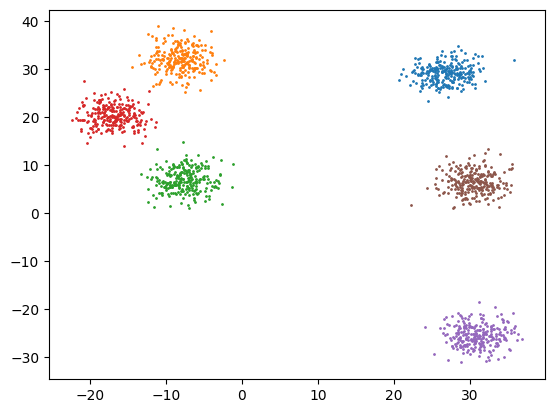

In [11]:
plot_data(slices)

In [12]:
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

In [13]:
data[:,0].shape # all xs, [:,1] all ys

torch.Size([1500])

In [14]:
def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x, f(x))

## DBScan Definition

Consider a set of points in some space to be clustered. Let ε be a parameter specifying the radius of a neighborhood with respect to some point. For the purpose of DBSCAN clustering, the points are classified as core points, (directly-) reachable points and outliers, as follows:

- A point p is a core point if at least minPts points are within distance ε of it (including p).
- A point q is directly reachable from p if point q is within distance ε from core point p. Points are only said to be directly reachable from core points.
- A point q is reachable from p if there is a path p1, ..., pn with p1 = p and pn = q, where each pi+1 is directly reachable from pi. Note that this implies that the initial point and all points on the path must be core points, with the possible exception of q.
- All points not reachable from any other point are outliers or noise points.

Now if p is a core point, then it forms a cluster together with all points (core or non-core) that are reachable from it. Each cluster contains at least one core point; non-core points can be part of a cluster, but they form its "edge", since they cannot be used to reach more points. 

A cluster [then] satisfies two properties:

1. All points within the cluster are mutually density-connected.
2. If a point is density-reachable from some point of the cluster, it is part of the cluster as well.

The DBSCAN algorithm can be abstracted into the following steps:

1. Find the points in the ε (eps) neighborhood of every point, and identify the core points with more than minPts neighbors.
2. Find the connected components of core points on the neighbor graph, ignoring all non-core points.
3. Assign each non-core point to a nearby cluster if the cluster is an ε (eps) neighbor, otherwise assign it to noise.

https://en.wikipedia.org/wiki/DBSCAN#Abstract_algorithm

## Non-parallelized implementation

In [15]:
eps = 0.5 # max distance to be considered neighbours
min_pts = 5 # min points

In [16]:
X = data.clone()
x = data[:5]

In [17]:
data[0].shape

torch.Size([2])

In [18]:
def is_neighbour(point, other_points, eps):
    return (((point-other_points)**2).sum(dim=1) <= eps)

In [19]:
foo = {}
"bar" not in foo

True

In [20]:
for i in torch.nonzero(is_neighbour(x[0], X, eps)).squeeze():
    print(i, X[i])

tensor(0) tensor([26.204, 26.349])
tensor(72) tensor([25.807, 26.060])
tensor(151) tensor([26.459, 26.723])
tensor(182) tensor([26.446, 26.410])
tensor(194) tensor([26.814, 26.671])
tensor(208) tensor([26.085, 25.912])
tensor(215) tensor([26.843, 26.434])
tensor(221) tensor([25.865, 26.078])
tensor(233) tensor([26.895, 26.417])
tensor(239) tensor([25.534, 26.495])


In [21]:
torch.nonzero(is_neighbour(x[0], X, 0.5)).squeeze().tolist()

[0, 72, 151, 182, 194, 208, 215, 221, 233, 239]

In [186]:
def is_neighbour(point, other_points, eps):
    return (((point-other_points)**2).sum(dim=1).sqrt() <= eps)

def build_groups(group_data, group_count, data_length):
    groups = []
    
    for i in range(1, group_count):
        group_indexes = list(filter(lambda key: group_data[key] == i, group_data.keys()))
        group = X[group_indexes]
        groups.append(group)

    noise_indexes = list(filter(lambda key: key not in group_data or group_data[key] == "noise", list(range(0, data_length)))) # only expecting "not in" scenario if called as callback

    if len(noise_indexes) > 0:
        noise = X[noise_indexes]
        groups.append(noise)

    return groups

def dbscan(data, eps=0.5, min_pts=5, callback=lambda point_to_group, group_count, data_length: None):
    n = len(data)
    X = data.clone()

    point_to_group = {}
    group_label = 0
    
    for i in range(0, n):
        if i in point_to_group:
            continue
        
        datum = X[i]

        is_core_point = is_neighbour(datum, X, eps).sum() - 1 >= min_pts # subtract one as datapoint itself will also register as neighbour but shouldn't be counted
        
        if not is_core_point:
            point_to_group[i] = "noise"
            continue

        group_label = group_label + 1
        
        point_to_group[i] = group_label

        neighbour_indexes = torch.nonzero(is_neighbour(datum, X, eps)).squeeze().tolist()

        for ni in neighbour_indexes:
            if ni in point_to_group and point_to_group[ni] == "noise":
                point_to_group[ni] = group_label

            if ni in point_to_group:
                continue

            point_to_group[ni] = group_label

            recursed_neighbour_indexes = torch.nonzero(is_neighbour(X[ni], X, eps)).squeeze().tolist()
            recursed_neighbour_indexes = list(set(recursed_neighbour_indexes).difference(set(neighbour_indexes)))

            neighbour_indexes.extend(recursed_neighbour_indexes)

        callback(point_to_group, group_label+1, n)

    return build_groups(point_to_group, group_label+1, n)

In [187]:
clusters = dbscan(X, eps=0.5, min_pts=5)
clusters[0][:5]

tensor([[26.204, 26.349],
        [25.807, 26.060],
        [26.459, 26.723],
        [26.446, 26.410],
        [26.085, 25.912]])

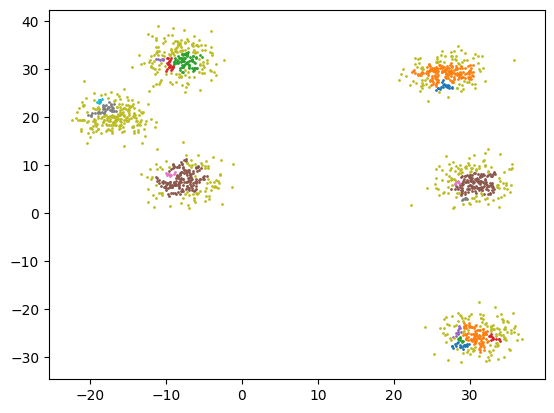

In [188]:
plot_data(clusters)

## Animation

In [25]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [26]:
intermediary_groups = []

def callback(group_data, group_count, data_length):
    intermediary_groups.append(build_groups(group_data, group_count, data_length))

dbscan(X, eps=0.5, min_pts=5, callback=callback)

final_group_len = len(intermediary_groups[-1])
group_count = len(intermediary_groups)

In [27]:
group_iterator = iter(intermediary_groups)

def plot_fn(d):
    ax.clear()
    
    next_data = next(group_iterator)
    group_len = len(next_data)

    noise_group = next_data.pop()

    next_data.extend([torch.empty(0, 2) for _ in range(final_group_len-group_len)]) # pad to keep group count and animation colours consistent
    
    next_data.append(noise_group)

    return plot_data(next_data, ax)

In [33]:
torch.empty(0, 2), torch.empty(0, 2)[:,0], torch.empty(0, 2)[:,1]

(tensor([], size=(0, 2)), tensor([]), tensor([]))

In [29]:
# create your own animation
fig,ax = plt.subplots()

ani = FuncAnimation(fig, plot_fn, frames=group_count-1, interval=1000, repeat=False)
plt.close()
HTML(ani.to_jshtml())

In [30]:
%timeit -n 5 _= dbscan(X, eps=0.5, min_pts=5)

96.8 ms ± 5.79 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


## Modifying for GPU parallelizability

In [34]:
import torch.nn as nn

In [94]:
X = data.clone()
x = data[:5]

In [95]:
X.shape, x.shape, x[:,None,:].shape, X[None].shape, (x[:,None,:]-X[None]).shape

(torch.Size([1500, 2]),
 torch.Size([5, 2]),
 torch.Size([5, 1, 2]),
 torch.Size([1, 1500, 2]),
 torch.Size([5, 1500, 2]))

In [96]:
(((x[:,None,:]-X[None])**2).sum(dim=2).sqrt() <= eps).sum(dim=1) > 5

tensor([True, True, True, True, True])

In [114]:
def euclidean_distance(points, other_points):
    return torch.einsum('ijk,ijk->ij', points-other_points, points-other_points).sqrt()

In [115]:
def is_core_point(batch, other_points, eps=2, min_neighbours=5):
    return (euclidean_distance(batch[:,None,:], other_points[None]) <= eps).sum(dim=1) >= min_neighbours

In [116]:
s = slice(0, 500)

In [117]:
X[s].shape, X[s][is_core_point(X[s], X)].shape

(torch.Size([500, 2]), torch.Size([491, 2]))

In [118]:
labels = -torch.ones(1500, dtype=torch.int32)
labels

tensor([-1, -1, -1,  ..., -1, -1, -1], dtype=torch.int32)

In [119]:
n = len(data)
X = data.clone()
labels = -torch.ones(n)

core_point_mask = is_core_point(X, other_points=X, eps=eps, min_neighbours=min_pts)
core_points = X[core_point_mask]
noise = X[~core_point_mask]

core_points.shape, noise.shape

(torch.Size([534, 2]), torch.Size([966, 2]))

In [120]:
def connections(points, other_points):
    differences = points[:,None,:] - other_points[None]
    return torch.einsum('ijk,ijk->ij', differences, differences).sqrt()

In [121]:
connections(core_points, core_points)

tensor([[ 0.000,  3.899,  3.726,  ..., 20.239, 19.241, 21.617],
        [ 3.899,  0.000,  0.185,  ..., 24.120, 23.134, 25.500],
        [ 3.726,  0.185,  0.000,  ..., 23.954, 22.965, 25.333],
        ...,
        [20.239, 24.120, 23.954,  ...,  0.000,  1.269,  1.380],
        [19.241, 23.134, 22.965,  ...,  1.269,  0.000,  2.491],
        [21.617, 25.500, 25.333,  ...,  1.380,  2.491,  0.000]])

In [123]:
from scipy.sparse.csgraph import connected_components

In [124]:
adjacency_graph = connections(core_points, core_points) <= eps
adjacency_graph

tensor([[ True, False, False,  ..., False, False, False],
        [False,  True,  True,  ..., False, False, False],
        [False,  True,  True,  ..., False, False, False],
        ...,
        [False, False, False,  ...,  True, False, False],
        [False, False, False,  ..., False,  True, False],
        [False, False, False,  ..., False, False,  True]])

In [125]:
torch.allclose(adjacency_graph, adjacency_graph.T)

True

In [126]:
_,labels = connected_components(adjacency_graph, directed=False)
labels[:20]

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 0, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [148]:
labels_tensor = torch.tensor(labels)
sorted_indices = torch.argsort(labels_tensor)
sorted_labels = labels_tensor[sorted_indices]

unique_labels, counts = torch.unique(sorted_labels, return_counts=True)
index_groups = torch.split(sorted_indices, counts.tolist())

index_groups[:10]

(tensor([ 42,  83,  79,  74,  72,  65,  93,  94,  30, 102,  13,   0]),
 tensor([ 55,   5,  63,  90,  61,  91,  59,  58,  57,  56,  88,  54,  53,  52,  51,  92,   6,   7,  75,   1,  85,  81,  80,   2,  78,  77,
          76,  66,   3,  73,   4,  71,  70,  69,  68,  47,  20,  11,  29,  28, 105,  24,  23,  22,  21,   8,  19,  18,  17,  16,  15,  14,
          12,  37,  46,  45,  44,  43,  41,  95,  39,  97,  31,  35,  99,  33, 101]),
 tensor([9]),
 tensor([ 98, 103,  84,  89,  10,  34,  25,  67,  36,  62,  60,  38,  40]),
 tensor([ 50,  26,  48,  49, 104]),
 tensor([ 82, 106,  27,  96,  87,  32]),
 tensor([100,  64]),
 tensor([86]),
 tensor([151, 150, 149, 173, 147, 174, 144, 143, 139, 176, 179, 134, 170, 152, 172, 156, 158, 160, 161, 162, 163, 164, 165, 166, 167, 180,
         107, 110, 111, 112, 113, 114, 115, 116, 117, 185, 119, 184, 183, 123, 125, 132, 126, 130, 129, 128, 181]),
 tensor([175, 108, 178, 177, 137, 159, 157, 141, 142, 153, 127, 145, 122]))

In [136]:
edge_analysis = connections(noise, core_points)
core_points.shape, noise.shape, edge_analysis.shape

(torch.Size([534, 2]), torch.Size([966, 2]), torch.Size([966, 534]))

In [144]:
edge_adjacency = (edge_analysis <= eps).int()
edge_adjacency

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)

In [158]:
edges_and_noise = torch.where(
    edge_adjacency.any(dim=1),  # Check if any column matches in each row
    edge_adjacency.argmax(dim=1),  # Get index of first True
    torch.tensor(-1)  # Set to -1 if no match
)
edges_and_noise[:10]

tensor([-1, -1, -1, -1, -1, -1, -1, -1, 25, -1])

In [163]:
noise_mask = edges_and_noise == -1
noise[noise_mask].shape

torch.Size([670, 2])

In [165]:
mask = torch.isin(edges_and_noise, index_groups[0])
noise[mask]

tensor([[27.664, 26.022],
        [25.599, 25.693],
        [26.598, 27.024],
        [26.085, 25.912]])

In [ ]:
def euclidean_distances(points, other_points):
    differences = points[:,None,:] - other_points[None]
    return torch.einsum('ijk,ijk->ij', differences, differences).sqrt()

In [ ]:
def connected_component_groups(core_points):
    adjacency_graph = euclidean_distances(core_points, core_points) <= eps
    
    _,labels = connected_components(adjacency_graph, directed=False)
    labels_tensor = torch.tensor(labels)
    sorted_indices = torch.argsort(labels_tensor)
    sorted_labels = labels_tensor[sorted_indices]
    
    unique_labels, counts = torch.unique(sorted_labels, return_counts=True)
    
    return torch.split(sorted_indices, counts.tolist())

In [ ]:
def edge_links_to_core_points(noise, core_points):
    distances = euclidean_distances(noise, core_points)
    is_edge = (edge_analysis <= eps).int()

    return torch.where(
        is_edge.any(dim=1),
        is_edge.argmax(dim=1),
        torch.tensor(-1)
    )

In [ ]:
def dbscan_parallelized(data, eps=0.5, min_pts=5): # Not sure how to support batching
    n = len(data)
    X = data.clone()
    
    core_point_mask = is_core_point(X, other_points=X, eps=eps, min_neighbours=min_pts)
    
    core_points = X[core_point_mask]
    non_core_points = X[~core_point_mask]

    ccgroups = connected_component_groups(core_points)
    edge_links = edge_links_to_core_points(non_core_points, core_points)

    result = []

    for ccgroup in ccgroups: # Not sure how to avoid for loop for tensors of uneven lengths
        result_group = core_points[ccgroup]
        
        edge_match_mask = torch.isin(edge_links, result_group)
        edge_matches = non_core_points[edge_match_mask]

        result.append(torch.cat([result_group, edge_matches]))
         
    noise_mask = edge_links == -1
    result.append(non_core_points[noise_mask])
    
    return result

In [183]:
clusters = dbscan_parallelized(X, eps=0.5, min_pts=5)
clusters[0][:5]

tensor([[27.103, 26.679],
        [26.814, 26.671],
        [26.446, 26.410],
        [26.955, 26.274],
        [27.196, 26.065]])

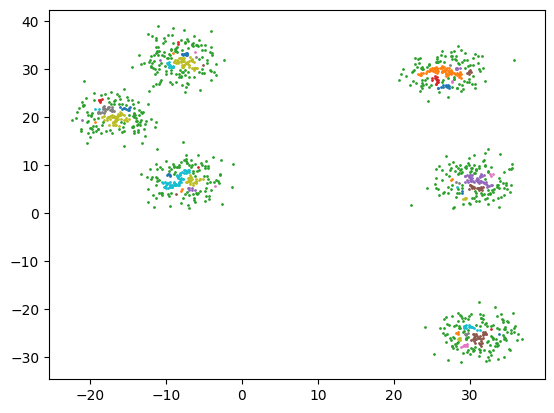

In [184]:
plot_data(clusters)

In [185]:
%timeit -n 5 _= dbscan_parallelized(X, eps=0.5, min_pts=5)

40.5 ms ± 5.81 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
